# Example 1: What price should I sell my used iphone for?
* This exmaple is taken from  http://www.statsathome.com/2017/10/12/bayesian-decision-theory-made-ridiculously-simple/

### The Problem
* Todo

In [166]:
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt
from functools import partial
from scipy.special import expit
from scipy.optimize import minimize_scalar
% matplotlib inline

In [2]:
train = pd.DataFrame({"sold": [1, 1, 0, 0, 1, 1], 
                     "scratched": [0, 0, 1, 0, 0, 0], 
                     "year": [2014, 2015, 2010, 2014, 2015, 2016],
                     "price": [50, 70, 40, 100, 90, 100]})

In [3]:
train

,price,scratched,sold,year
0,50,0,1,2014
1,70,0,1,2015
2,40,1,0,2010
3,100,0,0,2014
4,90,0,1,2015
5,100,0,1,2016


### The model
$$y_{\text{sold}, i} \sim \text{Bernoulli}(\pi_i)$$
$$\pi_i \sim \text{logit}^{-1}(\eta_i)$$
$$\eta_i \sim \beta_0 + \beta_1 \text{scratched}_i + \beta_2 \text{year_i} + \beta_3 \text{price}_i$$

### Priors
$$\beta_0 \sim \text{Uniform}$$
$$\beta_1 \sim \mathcal N(-1, 1)$$
$$\beta_2 \sim \mathcal N(1, 1) $$
$$\beta_2 \sim \mathcal N(-2, 1) $$

### Task
* Decide for price for a phone from 2014 without scratches

### Next Steps
* Instead of year take feature "years old"
* Include interaction terms
* Use GLM syntax

In [9]:
import pymc3 as pm

with pm.Model() as logistic_model:
    #sold ~ scratched + year + price, data = d, family = bernoulli(link = "logit"
    pm.glm.GLM.from_formula('sold ~ scratched + year + price', 
                            train, 
                            family=pm.glm.families.Binomial(), 
                            priors={'scratched': pm.Normal.dist(mu=-1, sd=1),
                                    'year': pm.Normal.dist(mu=1, sd=1),
                                    'price': pm.Normal.dist(mu=-2, sd=1)}
                            )
    trace_logistic_model = pm.sample(2000, chains=1, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|█████████▉| 2999/3000 [04:58<00:00, 10.04it/s]/usr/local/lib/python3.6/dist-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
100%|██████████| 3000/3000 [04:58<00:00, 10.04it/s]


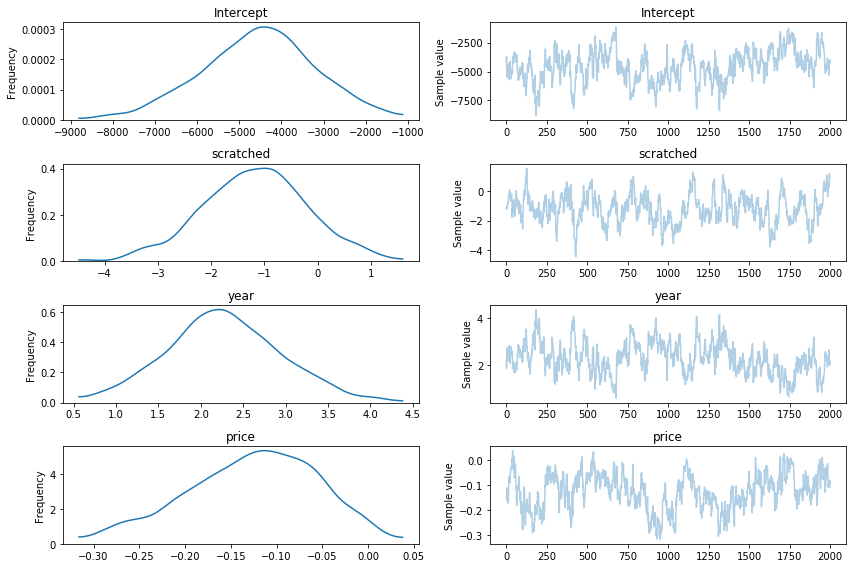

In [11]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace_logistic_model)
plt.tight_layout();

In [168]:
def predict(price, scratched, year, trace):
    linear = trace['Intercept'] + trace['scratched'] * scratched + trace['year'] * year + trace['price'] * price
    return expit(linear)

# probabilities for given phone
buy_probability = partial(predict, trace=trace_logistic_model, scratched=0, year=2014)

# expected utility function
expected_utility = lambda price: price.flatten() * buy_probability(price).mean(axis=1)

# Numerical optimum
optimum = minimize_scalar(lambda x: -expected_utility(np.array([[x]])).flatten()[0])['x']

70.81454874565104

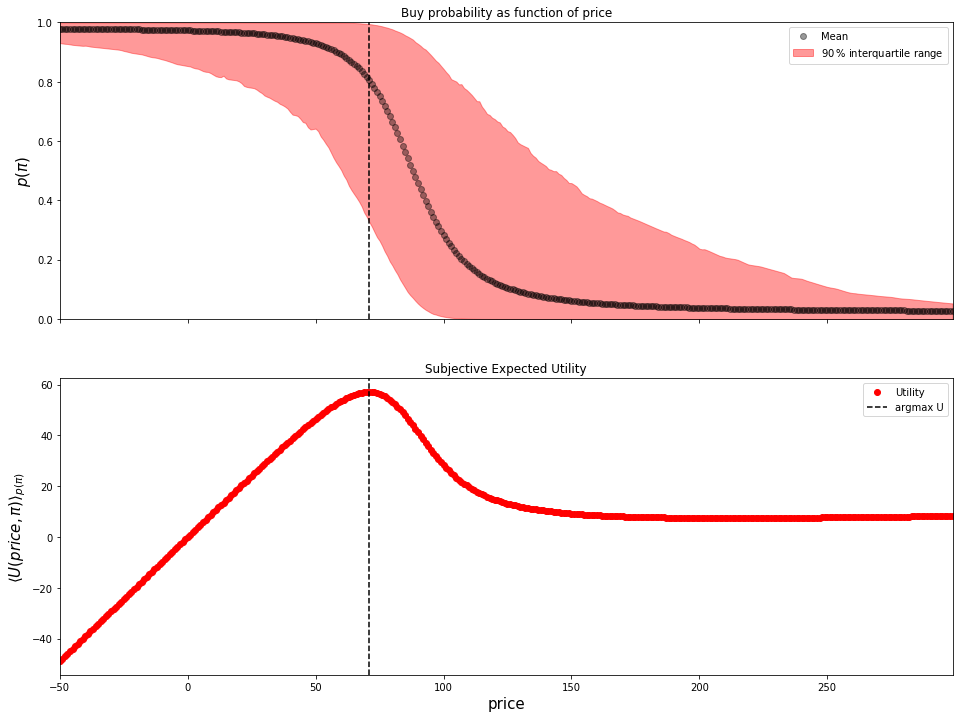

In [179]:
import numpy as np
prices = np.arange(-50, 300)[:,None]
probs = buy_probability(prices)
fig, ax = plt.subplots(nrows=2, figsize=(16,12), sharex=True)
ax[0].plot(prices, probs.mean(axis=1), 'o', color='black', alpha=0.4, label="Mean")
ax[0].fill_between(prices.flatten(), 
                np.percentile(probs, 5, axis=1), 
                np.percentile(probs, 95, axis=1), 
                color='red', 
                alpha=.4, 
                label=r"$90\,\%$ interquartile range")
ax[0].axvline(optimum, ls="--", color="black")
ax[0].set_ylabel(r"$p(\pi) $", fontsize=15)
ax[0].set_title("Buy probability as function of price")
ax[0].set_xlim(prices.min(), prices.max())
ax[0].set_ylim(0,1)
ax[0].legend()
ax[1].plot(prices, expected_utility(prices), "o", color="red", label="Utility")
ax[1].axvline(optimum, ls="--", color="black", label="argmax U")

ax[1].set_title("Subjective Expected Utility")
ax[1].set_ylabel(r"$\left \langle U(price, \pi)\right\rangle_{p(\pi)}$", fontsize=15)
ax[1].set_xlabel("price",  fontsize=15)
ax[1].legend();

# Example 2: Shall I take the bus?